# Data Extraction

In [1]:
import yfinance as yf

TICKERS = ['LIT','BATT','KARS', 'DRIV']
start_date = '2018-01-01'
end_date = '2025-11-18'

for ticker in TICKERS:
    df = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
    filename = f"{ticker}_historical_data.csv"
    df.to_csv(filename)

# Data Preparation

In [2]:
import pandas as pd
import warnings
from typing import Dict
warnings.filterwarnings('ignore')

CSV_FILES = {ticker: f'{ticker}_historical_data.csv' for ticker in TICKERS}

TRADING_DAYS_PER_YEAR = 252

ROLLING_RETURN_WINDOW = 252
ROLLING_VOL_WINDOW = 120

In [3]:
def load_price_data(csv_files: Dict[str, str]) -> Dict[str, pd.Series]:
    data = {}
    for ticker, filename in csv_files.items():
        try:
            df = pd.read_csv(filename, index_col=0, parse_dates=True)
            price_col = 'Adj Close' if 'Adj Close' in df.columns else 'Close'
            numeric_prices = pd.to_numeric(df[price_col], errors='coerce').dropna()
            numeric_prices.index = pd.to_datetime(numeric_prices.index)
            data[ticker] = numeric_prices
        except FileNotFoundError:
            print(f"Warning: File {filename} not found. Skipping {ticker}.")
        except Exception as e:
            print(f"Error loading {filename}: {e}")
    if not data:
        raise ValueError("No data loaded. Check file names and paths.")
    return data

# If you guys have different source of data, you might need to align them to common dates (e.g., HK and US markets have different holidays)
def align_series_to_common_index(data: Dict[str, pd.Series], tickers: list) -> pd.DataFrame: 
    common_index = data[tickers[0]].index
    for ticker in tickers:
        common_index = common_index.intersection(data[ticker].index)
    
    print(f"Common trading days: {len(common_index)}")
    
    aligned_prices = pd.DataFrame(index=common_index)
    for ticker in tickers:
        aligned_prices[ticker] = data[ticker].reindex(common_index)
    
    aligned_prices = aligned_prices.dropna()
    print(f"Final aligned prices shape: {aligned_prices.shape}")
    return aligned_prices

## Annualized Rolling Return

Unconditional expected return is estimated using a rolling window mean to capture time-varying performance. For each sector $i$, compute the rolling return $\mu^{(roll)}_{i,t}$ over a window of $w$ days:
$$
\mu^{(roll)}_{i,t}=\frac{1}{w}\sum^{w-1}_{k=0}r_{i,t-k},
$$
where $r_{i,t-k}$ is the return in the window.

$$
\mu^{(ann)}_{i,t} = \mu^{(roll)}_{i,t} \times 252,
$$

## Annualized Rolling Covariance Matrix

Unconditional covariance is estimated using a rolling window covariance matrix to capture time-varying correlations and joint risks across sectors. For each pair of sectors $i$ and $j$, compute the rolling covariance $\Sigma^{(roll)}_{i,j,t}$ over a window of $w$ days:
$$
\Sigma^{(roll)}_{i,j,t}=\frac{1}{w-1}\sum^{w-1}_{k=0}(r_{i,t-k}-\bar{r}_{i,t-k})(r_{j,t-k}-\bar{r}_{j,t-k}),
$$
where $\bar{r}_{i,t-k}$ and $\bar{r}_{j,t-k}$ are the mean returns in the window for sectors $i$ and $j$, respectively.

$$
\Sigma^{(ann)}_{i,j,t} = \Sigma^{(roll)}_{i,j,t} \times 252,
$$


In [4]:
import pandas as pd
import numpy as np

# Log Returns
def compute_log_returns(prices: pd.DataFrame) -> pd.DataFrame:
    log_returns = np.log(prices / prices.shift(1)).dropna()
    print(f"Log returns shape: {log_returns.shape}")
    return log_returns

# Annualized Rolling Return
def compute_annualized_rolling_return(returns: pd.DataFrame, window: int, trading_days: int) -> pd.DataFrame:
    rolling_mean = returns.rolling(window=window).mean() * trading_days
    annualized_return = rolling_mean.dropna()
    print(f"Annualized rolling return shape: {annualized_return.shape}")
    return annualized_return

# Annualized Rolling Covariance Matrix
def compute_annualized_rolling_cov_matrix(returns: pd.DataFrame, window: int, trading_days: int) -> pd.DataFrame:
    rolling_cov = returns.rolling(window=window).cov(ddof=1) * trading_days
    annualized_cov = rolling_cov.dropna()
    print(f"Annualized rolling covariance matrix shape: {annualized_cov.shape}")
    return annualized_cov

def clean_up_data(tickers: list, files: dict, rolling_return_window: int, rolling_vol_window: int, trading_days_per_year: int): 
    data = load_price_data(files)
    aligned_prices = align_series_to_common_index(data, tickers)
    log_returns = compute_log_returns(aligned_prices)
    annualized_rolling_return = compute_annualized_rolling_return(log_returns, window=rolling_return_window, trading_days=trading_days_per_year)["2020-01-01":"2025-11-17"]
    annualized_rolling_vol = compute_annualized_rolling_cov_matrix(log_returns, window=rolling_vol_window, trading_days=trading_days_per_year)["2020-01-01":"2025-11-17"]
    return data, aligned_prices, log_returns, annualized_rolling_return, annualized_rolling_vol 

In [5]:
#processed data: Made the function dynamic to process multiple datasets 

data, aligned_prices, log_returns, annualized_rolling_return, annualized_rolling_vol = clean_up_data(TICKERS, CSV_FILES, ROLLING_RETURN_WINDOW, ROLLING_VOL_WINDOW, TRADING_DAYS_PER_YEAR)

Common trading days: 1874
Final aligned prices shape: (1874, 4)
Log returns shape: (1873, 4)
Annualized rolling return shape: (1622, 4)
Annualized rolling covariance matrix shape: (7016, 4)


Total periods: 1478
Periods with all weights = 0 (100% cash): 431
Min weight sum: 0.000000
Max weight sum: 1.000010
Mean weight sum: 0.708390


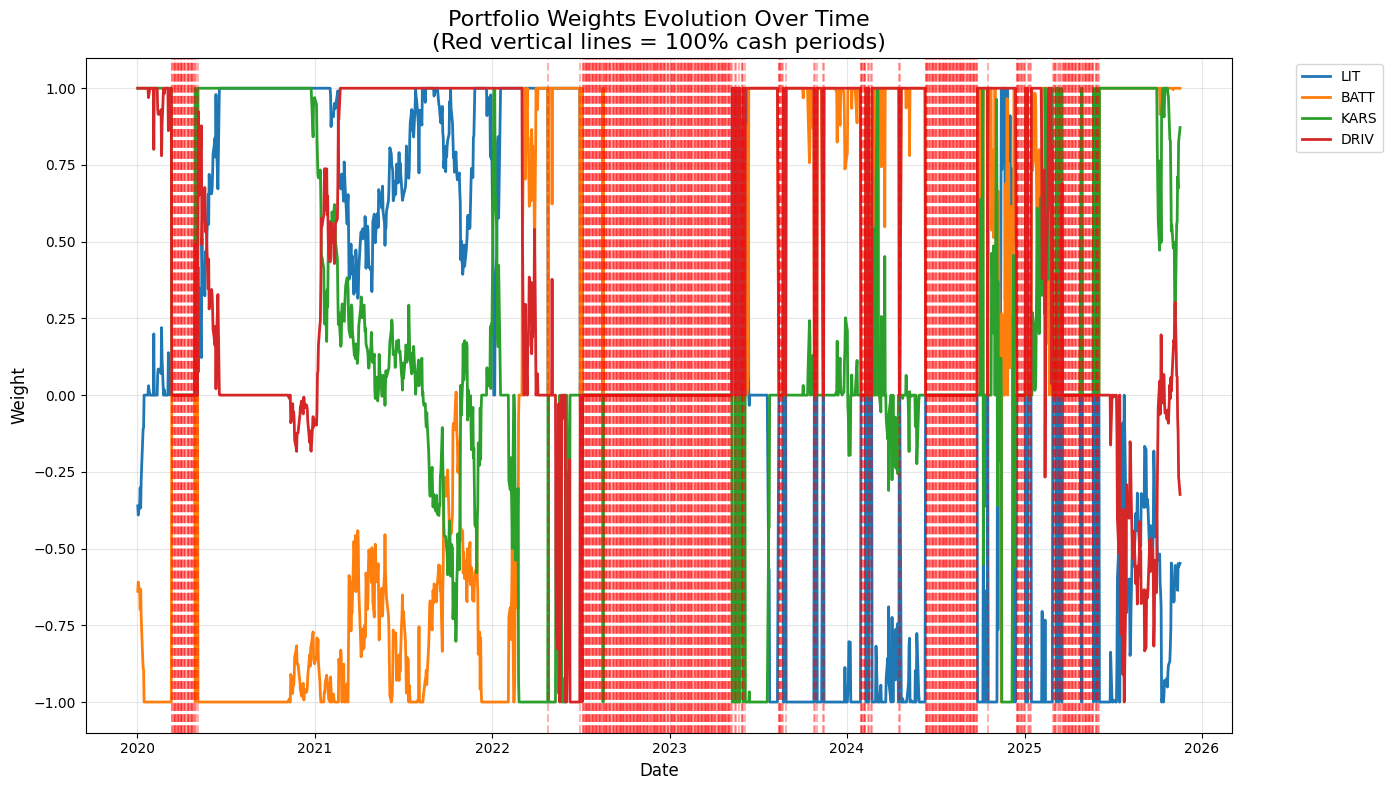

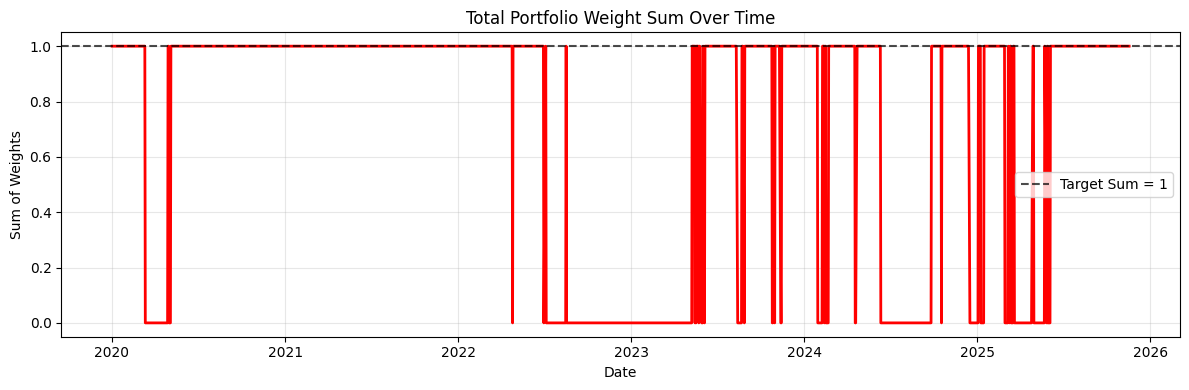


Weights summary:
               LIT         BATT         KARS         DRIV
count  1478.000000  1478.000000  1478.000000  1478.000000
mean      0.101574     0.030633     0.165978     0.410205
std       0.711721     0.759685     0.556905     0.544730
min      -1.000000    -1.000000    -1.000000    -1.000000
25%      -0.367150    -0.761238     0.000000     0.000000
50%       0.000000     0.000000     0.000000     0.000000
75%       0.884895     1.000000     0.569320     1.000000
max       1.000000     1.000000     1.000000     1.000000

Cash Holding Statistics:
Total periods with 100% cash: 431 (29.2%)
First cash period: 2020-03-12 00:00:00
Last cash period: 2025-06-03 00:00:00


In [6]:
from pypfopt.efficient_frontier import EfficientFrontier
import matplotlib.pyplot as plt

dates = annualized_rolling_return.index
weights_df = pd.DataFrame(index=dates, columns=TICKERS)

for date in dates:
    mu = annualized_rolling_return.loc[date]
    S = annualized_rolling_vol.xs(date, level=0)
    
    if all(mu <= 0):  # if all expected returns are non-positive
        cleaned_weights = {ticker: 0 for ticker in TICKERS}
    else:
        try:
            ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
            raw_weights = ef.max_sharpe()
            cleaned_weights = ef.clean_weights()
        except Exception as e:
            cleaned_weights = {ticker: 0 for ticker in TICKERS}
    
    for ticker in TICKERS:
        weights_df.loc[date, ticker] = cleaned_weights.get(ticker, 0)

weight_sums = weights_df.sum(axis=1)
zero_weight_periods = (weights_df == 0).all(axis=1).sum()

print(f"Total periods: {len(dates)}")
print(f"Periods with all weights = 0 (100% cash): {zero_weight_periods}")
print(f"Min weight sum: {weight_sums.min():.6f}")
print(f"Max weight sum: {weight_sums.max():.6f}")
print(f"Mean weight sum: {weight_sums.mean():.6f}")


weights_df = weights_df.astype(float)

plt.figure(figsize=(14, 8))
for ticker in TICKERS:
    plt.plot(weights_df.index, weights_df[ticker], label=ticker, linewidth=2)

zero_periods = weights_df.index[(weights_df == 0).all(axis=1)]
for period in zero_periods:
    plt.axvline(x=period, color='red', alpha=0.3, linestyle='--')

plt.title("Portfolio Weights Evolution Over Time\n(Red vertical lines = 100% cash periods)", fontsize=16)
plt.ylabel("Weight", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(weight_sums.index, weight_sums, color='red', linewidth=2)
plt.axhline(y=1.0, color='black', linestyle='--', alpha=0.7, label='Target Sum = 1')
plt.title("Total Portfolio Weight Sum Over Time")
plt.ylabel("Sum of Weights")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nWeights summary:")
print(weights_df.describe())

print(f"\nCash Holding Statistics:")
print(f"Total periods with 100% cash: {zero_weight_periods} ({(zero_weight_periods/len(dates))*100:.1f}%)")
if len(zero_periods) > 0:
    print(f"First cash period: {zero_periods[0]}")
    print(f"Last cash period: {zero_periods[-1]}")

In [7]:
zero_periods = weights_df.index[(weights_df == 0).all(axis=1)]

consecutive_groups = []
current_group = []

for date in sorted(zero_periods):
    if not current_group:
        current_group.append(date)
    else:
        if (date - current_group[-1]).days <= 7:
            current_group.append(date)
        else:
            if len(current_group) >= 14:  # Only keep periods with at least 14 days
                consecutive_groups.append(current_group)
            current_group = [date]

if current_group and len(current_group) >= 14:
    consecutive_groups.append(current_group)

print("Dense Cash Holding Periods:")
for i, group in enumerate(consecutive_groups, 1):
    start_date = group[0].strftime('%Y-%m-%d')
    end_date = group[-1].strftime('%Y-%m-%d')
    duration_days = (group[-1] - group[0]).days
    print(f"{i}. {start_date} to {end_date} ({len(group)} days, duration: {duration_days} days)")

Dense Cash Holding Periods:
1. 2020-03-12 to 2020-05-04 (35 days, duration: 53 days)
2. 2022-07-01 to 2023-06-05 (220 days, duration: 339 days)
3. 2024-06-11 to 2024-09-25 (74 days, duration: 106 days)
4. 2024-12-16 to 2025-01-14 (16 days, duration: 29 days)
5. 2025-02-28 to 2025-06-03 (57 days, duration: 95 days)


In [8]:
def calculate_portfolio_stats(weights_df, returns_df, cov_df):
    common_dates = weights_df.index.intersection(returns_df.index)
    weights_df = weights_df.loc[common_dates]
    returns_df = returns_df.loc[common_dates]

    portfolio_returns = (weights_df * returns_df).sum(axis=1)

    portfolio_volatility = pd.Series(index=common_dates, dtype=float)
    for date in common_dates:

        w = weights_df.loc[date].values
        
        if date in cov_df.index.get_level_values(0):
            cov_matrix = cov_df.loc[date].values
        else:
            available_dates = cov_df.index.get_level_values(0)
            nearest_date = available_dates[available_dates <= date][-1]
            cov_matrix = cov_df.loc[nearest_date].values
        
        portfolio_variance = w.T @ cov_matrix @ w
        
        portfolio_volatility[date] = np.sqrt(portfolio_variance * 252)
    
    return portfolio_returns, portfolio_volatility

portfolio_returns, portfolio_volatility = calculate_portfolio_stats(
    weights_df, annualized_rolling_return, annualized_rolling_vol
)

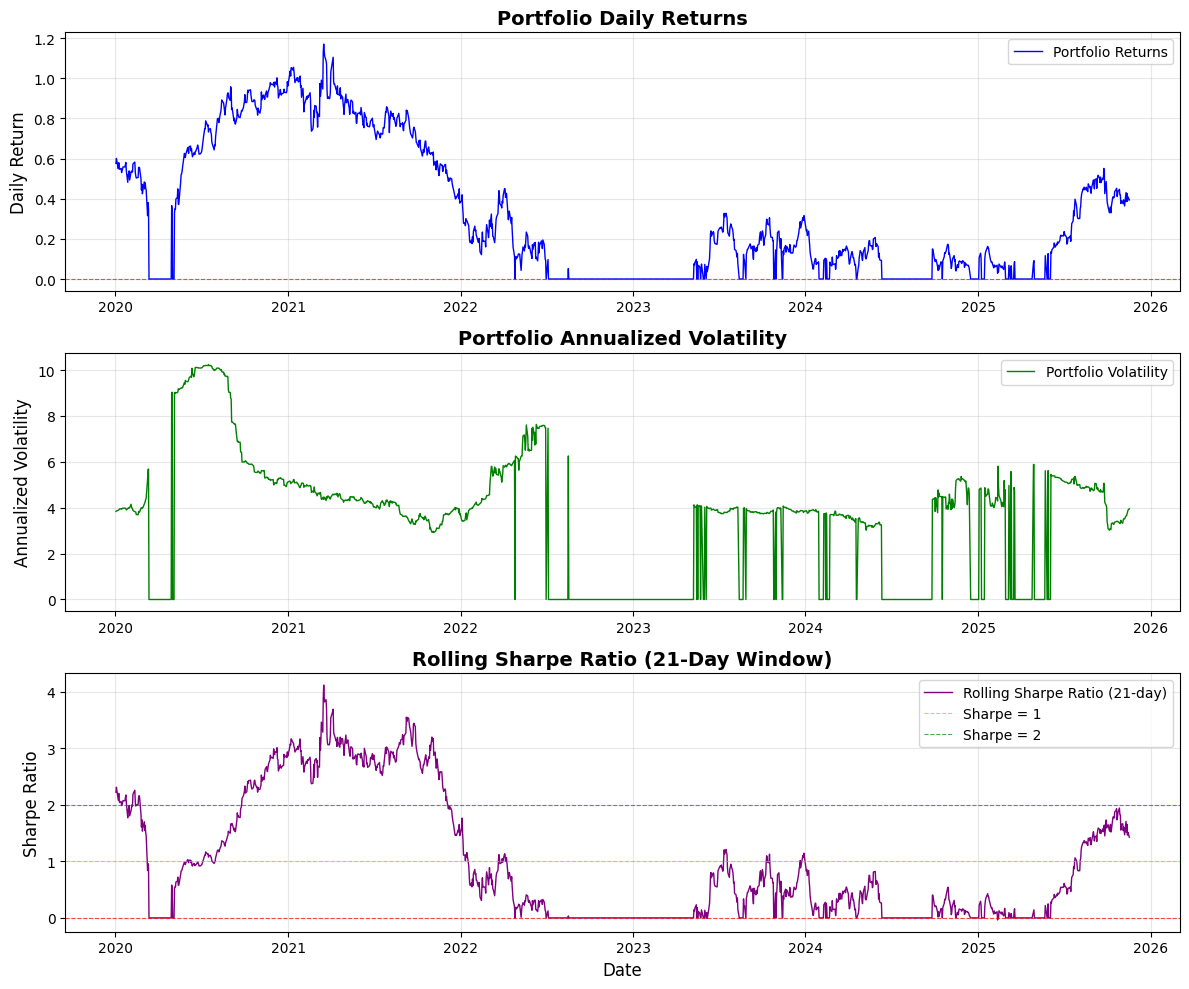

=== Sharpe Ratio Statistics ===
Average Sharpe Ratio: 0.9768
Max Sharpe Ratio: 4.1181
Min Sharpe Ratio: -0.0368
Std of Sharpe Ratio: 1.0948
Positive Sharpe Days: 1044 (70.6%)
Days with Sharpe > 1: 532 (36.0%)
Zero Volatility Days (100% Cash): 431


In [9]:
def plot_returns_volatility_timeseries(portfolio_returns, portfolio_volatility):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
    
    ax1.plot(portfolio_returns.index, portfolio_returns, color='blue', linewidth=1, label='Portfolio Returns')
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=0.8)
    ax1.set_title('Portfolio Daily Returns', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Daily Return', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(portfolio_volatility.index, portfolio_volatility, color='green', linewidth=1, label='Portfolio Volatility')
    ax2.set_title('Portfolio Annualized Volatility', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Annualized Volatility', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    sharpe_ratio = (portfolio_returns - 0.0386) * np.sqrt(252) / portfolio_volatility # hardcode risk-free rate
    sharpe_ratio = sharpe_ratio.replace([np.inf, -np.inf], 0) 
    sharpe_ratio[portfolio_volatility == 0] = 0  # Set to 0 when volatility is 0 (100% cash)
    
    ax3.plot(sharpe_ratio.index, sharpe_ratio, color='purple', linewidth=1, label='Rolling Sharpe Ratio (21-day)')
    ax3.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=0.8)
    ax3.axhline(y=1, color='orange', linestyle='--', alpha=0.7, linewidth=0.8, label='Sharpe = 1')
    ax3.axhline(y=2, color='green', linestyle='--', alpha=0.7, linewidth=0.8, label='Sharpe = 2')
    ax3.set_title('Rolling Sharpe Ratio (21-Day Window)', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Sharpe Ratio', fontsize=12)
    ax3.set_xlabel('Date', fontsize=12)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    sharpe_valid = sharpe_ratio.dropna()
    if len(sharpe_valid) > 0:
        print("=== Sharpe Ratio Statistics ===")
        print(f"Average Sharpe Ratio: {sharpe_valid.mean():.4f}")
        print(f"Max Sharpe Ratio: {sharpe_valid.max():.4f}")
        print(f"Min Sharpe Ratio: {sharpe_valid.min():.4f}")
        print(f"Std of Sharpe Ratio: {sharpe_valid.std():.4f}")
        print(f"Positive Sharpe Days: {(sharpe_valid > 0).sum()} ({(sharpe_valid > 0).sum()/len(sharpe_valid)*100:.1f}%)")
        print(f"Days with Sharpe > 1: {(sharpe_valid > 1).sum()} ({(sharpe_valid > 1).sum()/len(sharpe_valid)*100:.1f}%)")
        print(f"Zero Volatility Days (100% Cash): {(portfolio_volatility == 0).sum()}")

plot_returns_volatility_timeseries(portfolio_returns, portfolio_volatility)

In [10]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable



Tangency Portfolio (Rf = 4%):
LIT    -0.53999
BATT    1.00000
KARS    0.93354
DRIV   -0.39355
dtype: float64


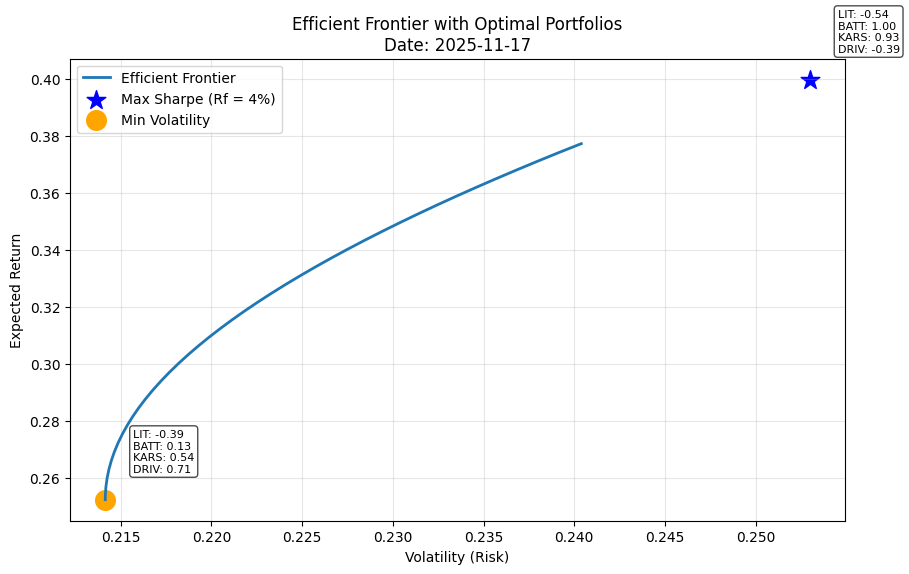

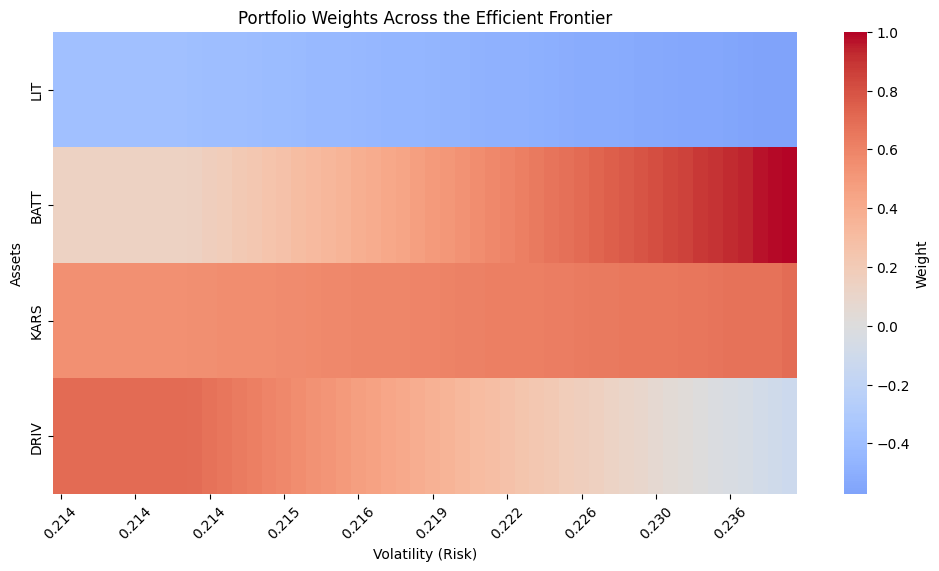

In [11]:
import seaborn as sns


#latest returns and covariance 
date = annualized_rolling_return.index[-1]
mu = annualized_rolling_return.loc[date]
S = annualized_rolling_vol.xs(date, level=0)

#efficient frontier sampling 
target_returns = np.linspace(mu.min(), mu.max(), 50)

risks = []
returns = []
weights_list = []

for tr in target_returns:
    try:
        ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
        ef.efficient_return(tr)
        ret, risk, _ = ef.portfolio_performance()
        risks.append(risk)
        returns.append(ret)
        weights_list.append(ef.clean_weights())
    except:
        risks.append(np.nan)
        returns.append(np.nan)
        weights_list.append({t: np.nan for t in mu.index})

# Convert weights list into dataframe
weights_df = pd.DataFrame(weights_list)
weights_df["risk"] = risks
weights_df["return"] = returns
weights_df = weights_df.dropna()


#the tangency portfolio at 4% risk free rate 
Rf = 0.04  # 4%

ef_rf = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
ef_rf.max_sharpe(risk_free_rate=Rf)
ret_rf, risk_rf, sharpe_rf = ef_rf.portfolio_performance(risk_free_rate=Rf)
weights_rf = ef_rf.clean_weights()

print("\nTangency Portfolio (Rf = 4%):")
print(pd.Series(weights_rf))

#fetch the minimum volatility ratio 
ef_min = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
ef_min.min_volatility()
ret_m, risk_m, _ = ef_min.portfolio_performance()
weights_min = ef_min.clean_weights()

#annotate the portfolio weights on the graph just for visibility 
def annotate_weights(x, y, weights):
    txt = "\n".join([f"{k}: {v:.2f}" for k, v in weights.items()])
    plt.annotate(txt, (x, y), xytext=(20, 20),
                 textcoords='offset points', fontsize=8,
                 bbox=dict(boxstyle="round,pad=0.3",
                           fc="white", alpha=0.7))

#plotting the efficient frontier and the best possible weights for each stock, 
#allowing the trader to select the risk level they are most comfortable with 
plt.figure(figsize=(10, 6))
plt.plot(weights_df["risk"], weights_df["return"],
         linewidth=2, label="Efficient Frontier")

# Max Sharpe
plt.scatter(risk_rf, ret_rf, s=200, marker='*', color='blue',
            label=f"Max Sharpe (Rf = {Rf*100:.0f}%)")

# Annotate weights
annotate_weights(risk_rf, ret_rf, weights_rf)

# Min Vol
plt.scatter(risk_m, ret_m, s=200, marker='o', color='orange',
            label="Min Volatility")

# Annotate weights
annotate_weights(risk_m, ret_m, weights_min)

plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.title(f"Efficient Frontier with Optimal Portfolios\nDate: {date.date()}")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


plt.figure(figsize=(12, 6))

#plot the heatmap for the data 
# 1. Prepare the data
heatmap_data = weights_df.set_index("risk").iloc[:, :-1].T

# 2. Format the column names (Risk values) to look nicer (e.g., 2 decimal places)
#    This changes "0.21539..." to just "0.22"
heatmap_data.columns = heatmap_data.columns.map(lambda x: f"{x:.3f}")

# 3. Plot with 'xticklabels' to control frequency
#    xticklabels=5 means "only show every 5th label"
sns.heatmap(heatmap_data, 
            cmap="coolwarm", 
            center=0,
            cbar_kws={'label':'Weight'},
            xticklabels=5) 

plt.title("Portfolio Weights Across the Efficient Frontier")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Assets")

# Optional: Rotate the x-labels so they are easier to read
plt.xticks(rotation=45) 

plt.show()


## Granger causality

Imagine a few rich people move into the neighborhood next to yours. Before the people moved into that neighborhood, the house prices there and in your neighborhood were relatively similar. However, after these rich individuals moved in, the house prices in that neighborhood began rising steadily. With house prices in that neighborhood rising, realtors in your neighborhood also began setting higher than usual house prices, resulting in an increase in property value. The simple change that happened in the next neighborhood affected the prices of your neighborhood. This is the Granger causality effect. In short, the changes in two different timeseries can have a degree of covariance, in that one timeseries affects another one. 

Based on this argument, the Granger causality effect measures how a separate timeseries affects the exisitng one. So, if the timeseries can be modeled as show below: 
$$Y_t = \alpha_0 + \sum_{i=1}^p \alpha_i Y_{t-i} + \sum_{i=1}^p \beta_i X_{t-i} + \epsilon_{Y,t} $$

The goal is to test the null hypothesis that timeseries X has an effect on timeseries Y. If the p-value is above a confidence level say of 0.05, then the two time series have no impact on each other, but if it goes below the set threshold, timseries X affects timeseries Y. 

$$X_t = \gamma_0 + \sum_{i=1}^p \gamma_i X_{t-i} + \sum_{i=1}^p \delta_i Y_{t-i} + \epsilon_{X,t} $$


In this equation above, the goal is to evaluate if timeseries Y has an effect on timeseries X's values. As seen in both cases, we use a lagged value from the other timeseries to evalute the impact of that value on the current timestep value of timeseries we are analyzing. If coefficents ${\beta}$ and ${\delta}$ are not equal to zero, then a relationship between both timeseries exist. 


In [12]:
from statsmodels.tsa.stattools import grangercausalitytests


TICKERS = ['LIT','BATT', 'KARS', 'DRIV']
MAX_GRANGER_LAG = 20  
ROLLING_CORR_WINDOW = 60 

price_data_series = load_price_data(CSV_FILES)
aligned_prices = align_series_to_common_index(price_data_series, TICKERS)
daily_returns_df = aligned_prices.pct_change().dropna()




# --- GRANGER CAUSALITY TEST ---
def analyze_granger_causality(df: pd.DataFrame, max_lag: int) -> pd.DataFrame:
    """Performs bidirectional Granger Causality test for all unique pairs."""
    
    granger_results = []
    
    for i in range(len(TICKERS)):
        for j in range(len(TICKERS)):
            if i == j:
                continue
                
            asset_x = TICKERS[i] # Cause/Predictor
            asset_y = TICKERS[j] # Effect/Predicted
            
            # Data ordered as [Predicted, Predictor]
            data = df[[asset_y, asset_x]].dropna()
            
            try:
                # Test up to max_lag in one call
                results = grangercausalitytests(data, maxlag=max_lag, verbose=False)
                
                # Analyze the results for all lags
                for lag in range(1, max_lag + 1):
                    # We typically use the F-test
                    ftest_p = results[lag][0]['ssr_ftest'][1]
                    
                    granger_results.append({
                        'Cause': asset_x,
                        'Effect': asset_y,
                        'Lag_Days': lag,
                        'P_Value': ftest_p,
                        'Causality': 'Yes' if ftest_p < 0.05 else 'No'
                    })
            except Exception:
                # Handle cases where data is insufficient for the test
                pass
                
    return pd.DataFrame(granger_results)

# Run the full Granger analysis
granger_df = analyze_granger_causality(daily_returns_df, MAX_GRANGER_LAG)

Common trading days: 1874
Final aligned prices shape: (1874, 4)


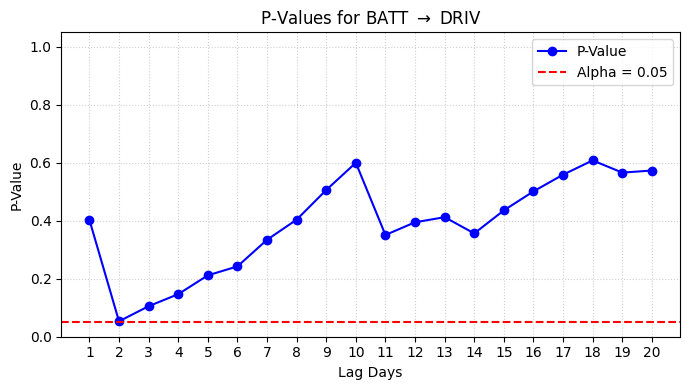

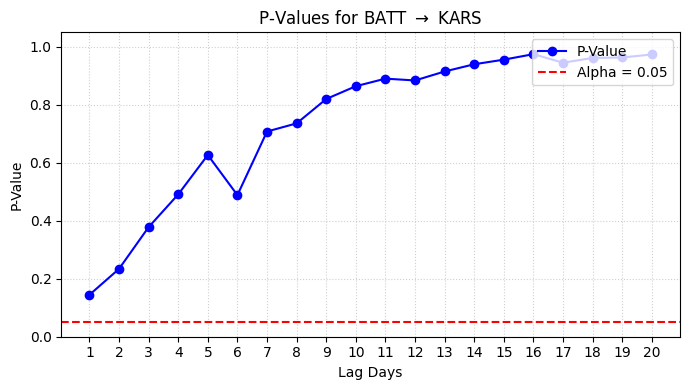

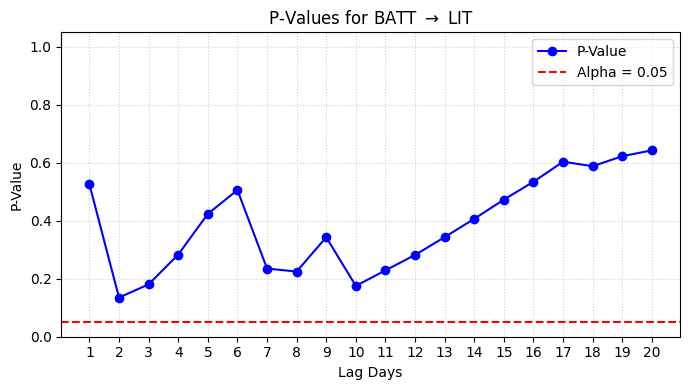

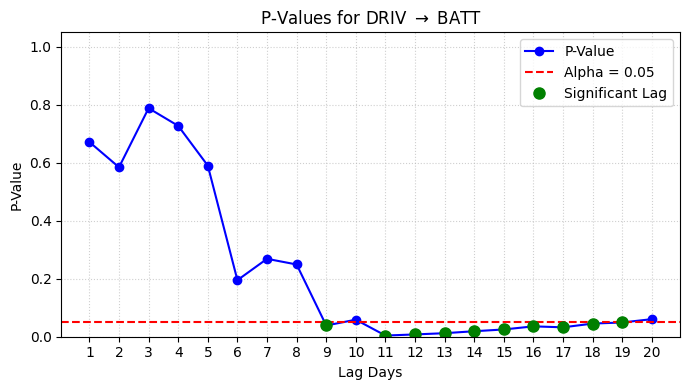

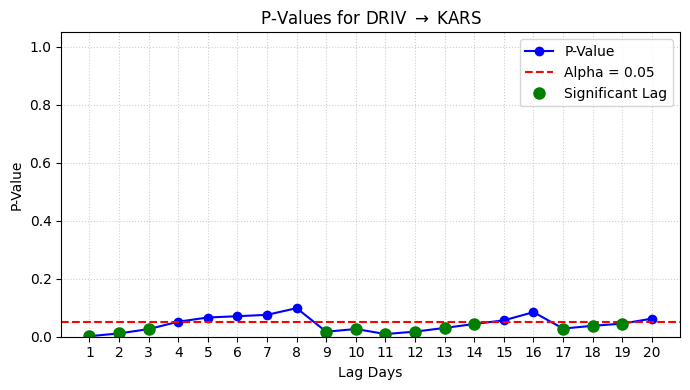

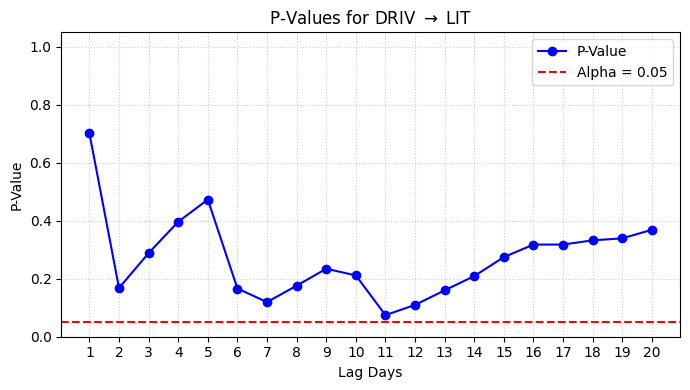

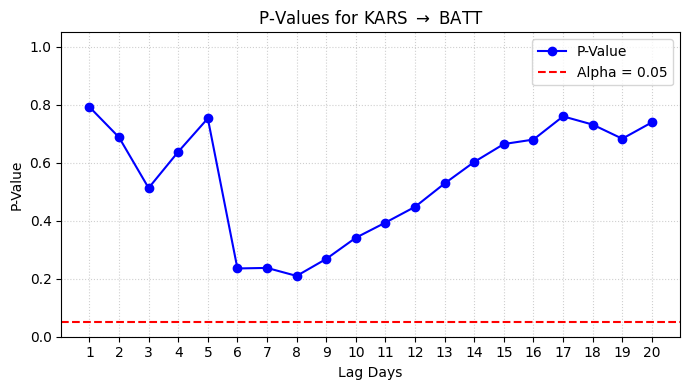

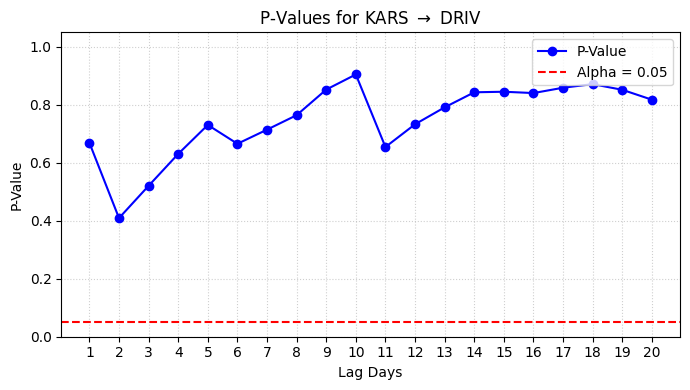

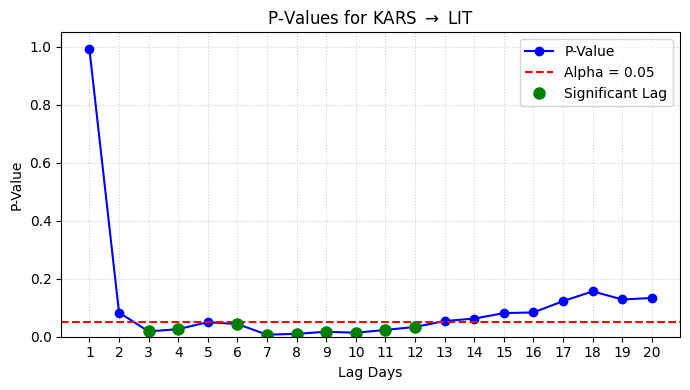

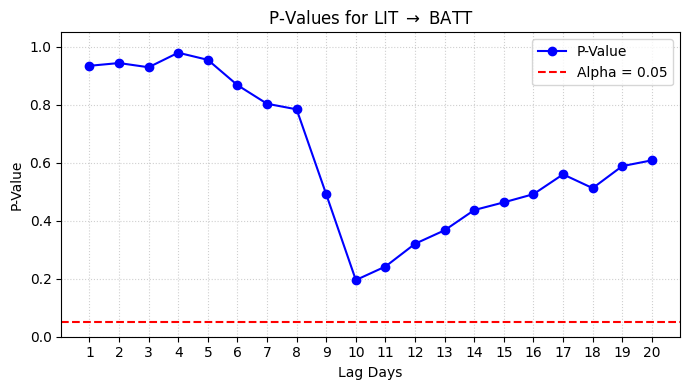

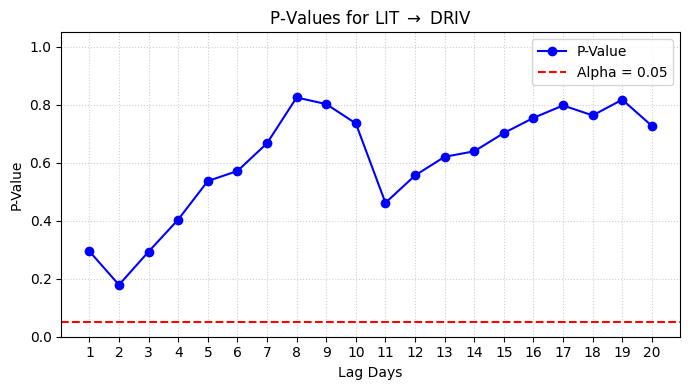

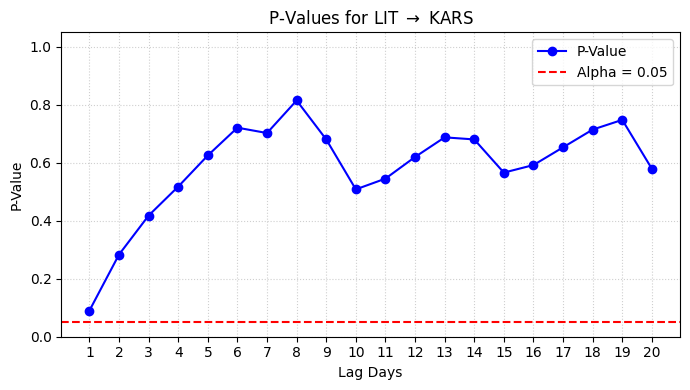

In [25]:
alpha = 0.05
grouped_results = granger_df.groupby(['Cause', 'Effect'])
unique_pairs = granger_df[['Cause', 'Effect']].drop_duplicates().shape[0]
for name, group in grouped_results:
    cause = name[0]
    effect = name[1]

    plt.figure(figsize=(7, 4))
    
    # Plot the P-values
    plt.plot(group['Lag_Days'], group['P_Value'], 
             marker='o', linestyle='-', color='b', label='P-Value')
    
    # Add the significance threshold line (the crucial element)
    plt.axhline(y=alpha, color='r', linestyle='--', label=f'Alpha = {alpha}')
    
    # Highlight significant lags (where P-Value < alpha)
    significant_lags = group[group['P_Value'] < alpha]
    if not significant_lags.empty:
        plt.plot(significant_lags['Lag_Days'], significant_lags['P_Value'], 
                 'o', color='g', markersize=8, label='Significant Lag')
    
    # Add labels and title
    plt.title(f'P-Values for {cause} $\\to$ {effect}')
    plt.xlabel('Lag Days')
    plt.ylabel('P-Value')
    plt.xticks(group['Lag_Days']) # Ensure all lag days are shown
    plt.ylim(0, 1.05) # Set y-limit from 0 to slightly above 1
    plt.legend(loc='upper right')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    
    plt.show()

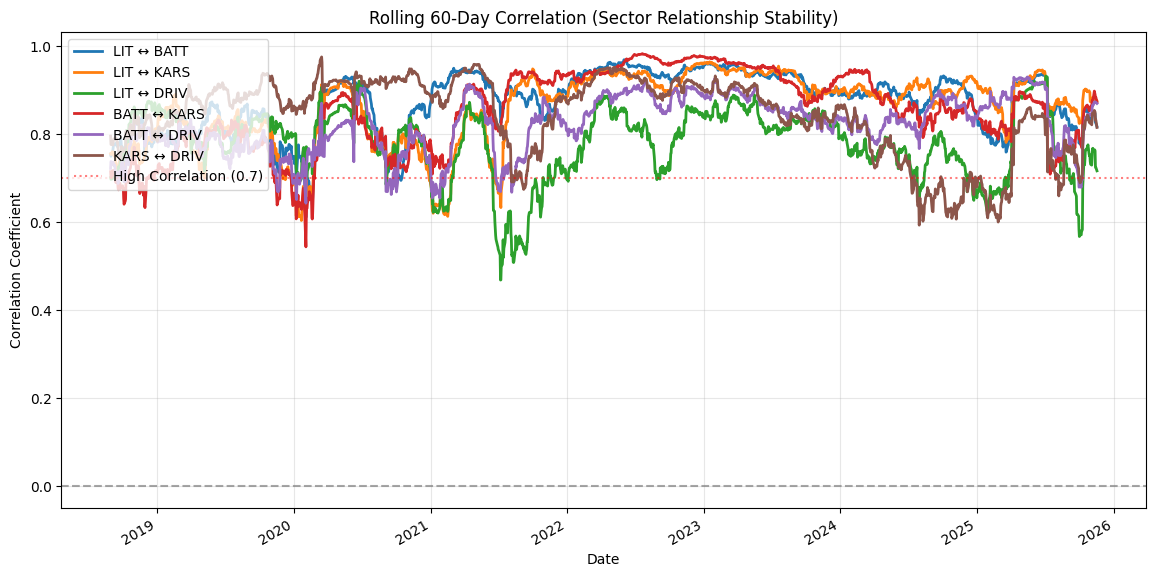

In [14]:
# --- ROLLING CORRELATION ANALYSIS ---

# Calculate rolling correlations for all unique pairs
rolling_corrs = pd.DataFrame(index=daily_returns_df.index)

for i in range(len(TICKERS)):
    for j in range(i + 1, len(TICKERS)):
        ticker1 = TICKERS[i]
        ticker2 = TICKERS[j]
        
        corr_series = daily_returns_df[ticker1].rolling(window=ROLLING_CORR_WINDOW).corr(daily_returns_df[ticker2])
        rolling_corrs[f'{ticker1} ↔ {ticker2}'] = corr_series

plt.figure(figsize=(14, 7))
rolling_corrs.plot(ax=plt.gca(), linewidth=2)
plt.title(f'Rolling {ROLLING_CORR_WINDOW}-Day Correlation (Sector Relationship Stability)')
plt.xlabel('Date')
plt.ylabel('Correlation Coefficient')
plt.axhline(0.7, color='red', linestyle=':', alpha=0.5, label='High Correlation (0.7)')
plt.axhline(0, color='grey', linestyle='--', alpha=0.7)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()



In [15]:
UPSTREAM_TICKERS = ['9696.HK', '1772.HK']
MIDSTREAM_TICKERS = ['9866.HK', '3750.HK']
DOWNSTREAM_TICKERS = ['1211.HK', '0175.HK']

TICKERS = UPSTREAM_TICKERS + MIDSTREAM_TICKERS + DOWNSTREAM_TICKERS
start_date = '2018-01-01'
end_date = '2025-11-18'

for ticker in TICKERS:
    df = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
    filename = f"{ticker}_historical_data.csv"
    df.to_csv(filename)

In [17]:
warnings.filterwarnings('ignore')
sector_map = {
    'Upstream_Resources': ['9696.HK', '1772.HK'],
    'Midstream_Manufacturing': ['9866.HK', '3750.HK'],
    'Downstream_Application': ['1211.HK', '0175.HK']
}
CSV_FILES_2 = {ticker: f'{ticker}_historical_data.csv' for ticker in TICKERS}

TRADING_DAYS_PER_YEAR = 252

ROLLING_RETURN_WINDOW = 252
ROLLING_VOL_WINDOW = 120

#processed data: Made the function dynamic to process multiple datasets 

data, aligned_prices, log_returns, annualized_rolling_return, annualized_rolling_vol = clean_up_data(TICKERS, CSV_FILES_2, ROLLING_RETURN_WINDOW, ROLLING_VOL_WINDOW, TRADING_DAYS_PER_YEAR)

Common trading days: 126
Final aligned prices shape: (126, 6)
Log returns shape: (125, 6)
Annualized rolling return shape: (0, 6)
Annualized rolling covariance matrix shape: (36, 6)


In [18]:
def construct_sector_indices(aligned_prices: pd.DataFrame, sector_map: dict) -> pd.DataFrame:
    """Calculates daily returns and constructs the equally weighted index for each sector."""
    
    daily_returns_df = aligned_prices.pct_change().dropna()
    sector_indices = pd.DataFrame(index=daily_returns_df.index)
    
    for sector, tickers in sector_map.items():
        # 1. Calculate the equal weight return for the sector
        sector_returns = daily_returns_df[tickers].mean(axis=1)
        
        # 2. Convert returns to an index (Base date 2020.1.2 = 100)
        # Use a base value of 100
        sector_indices[f'{sector}_Return'] = sector_returns
        sector_indices[f'{sector}_Index'] = (1 + sector_returns).cumprod() * 100
        
    return sector_indices

In [19]:
sector_indices_df = construct_sector_indices(aligned_prices, sector_map)

Full-Period Correlation Matrix:
            Upstream  Midstream  Downstream
Upstream      1.0000     0.2892      0.4199
Midstream     0.2892     1.0000      0.5057
Downstream    0.4199     0.5057      1.0000
--------------------------------------------------


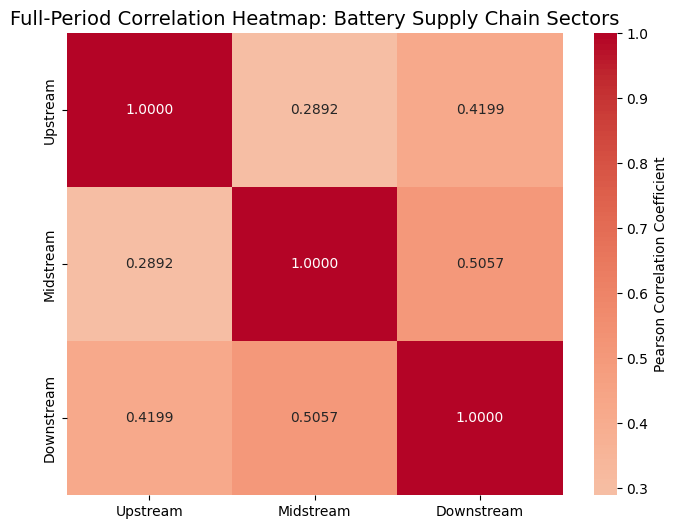

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the daily return columns for the three sectors
sector_returns = sector_indices_df[[
    'Upstream_Resources_Return',
    'Midstream_Manufacturing_Return',
    'Downstream_Application_Return'
]]

# Rename columns for cleaner display in the heatmap
sector_returns.columns = ['Upstream', 'Midstream', 'Downstream']

# Calculate the Full-Period Correlation Matrix
correlation_matrix = sector_returns.corr(method='pearson')

print("Full-Period Correlation Matrix:")
print(correlation_matrix.round(4))
print("-" * 50)

# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,          
    fmt=".4f",           
    cmap='coolwarm',    
    center=0,           
    cbar_kws={'label': 'Pearson Correlation Coefficient'}
)
plt.title('Full-Period Correlation Heatmap: Battery Supply Chain Sectors', fontsize=14)
plt.show()

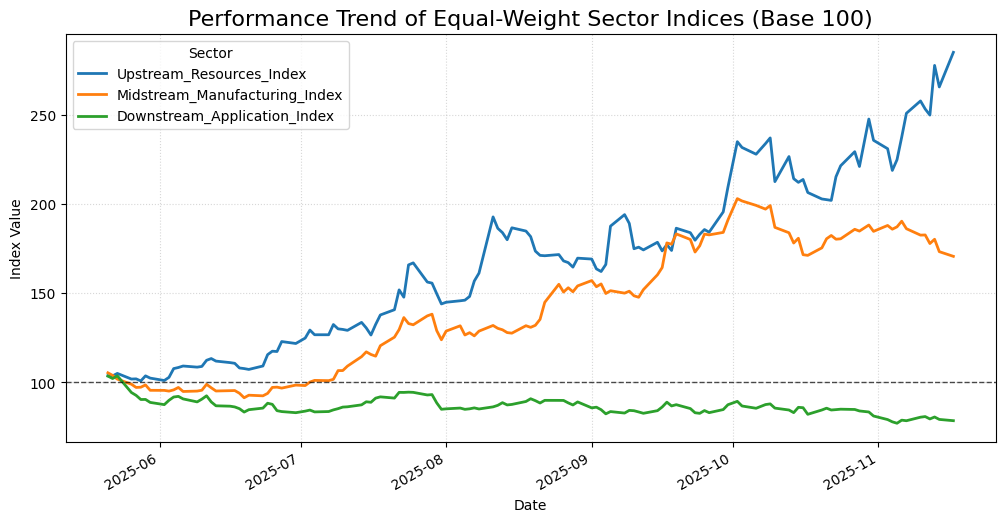

In [21]:
# 1. Extract the index level columns
sector_indices = sector_indices_df[[
    'Upstream_Resources_Index',
    'Midstream_Manufacturing_Index',
    'Downstream_Application_Index'
]]

# 2. Plot the indices
plt.figure(figsize=(12, 6))
sector_indices.plot(ax=plt.gca(), linewidth=2)

plt.title('Performance Trend of Equal-Weight Sector Indices (Base 100)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend(loc='upper left', title='Sector')
plt.axhline(100, color='black', linestyle='--', linewidth=1, alpha=0.7) # Base line at 100
plt.show()

In [22]:
indices_granger_df = analyze_granger_causality(aligned_prices, MAX_GRANGER_LAG)
indices_daily_return = aligned_prices.pct_change().dropna()

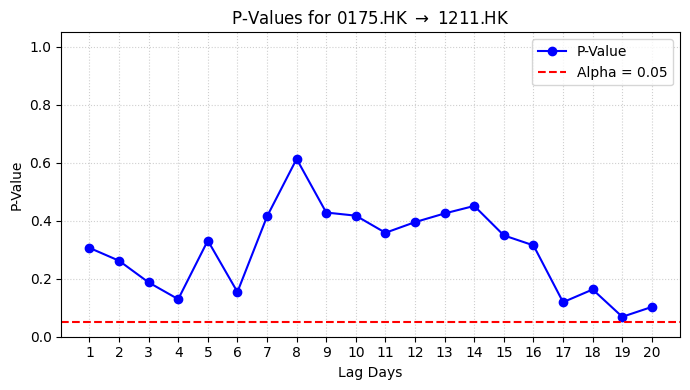

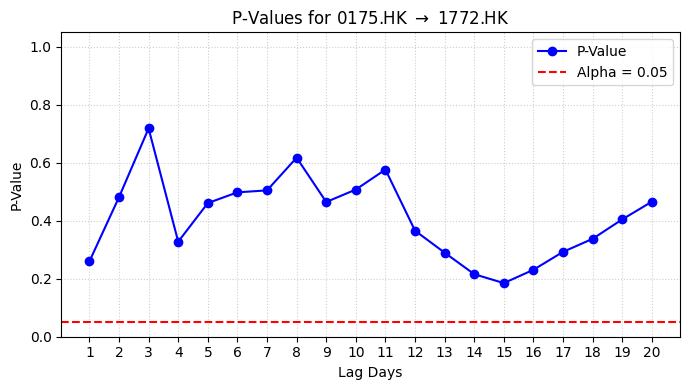

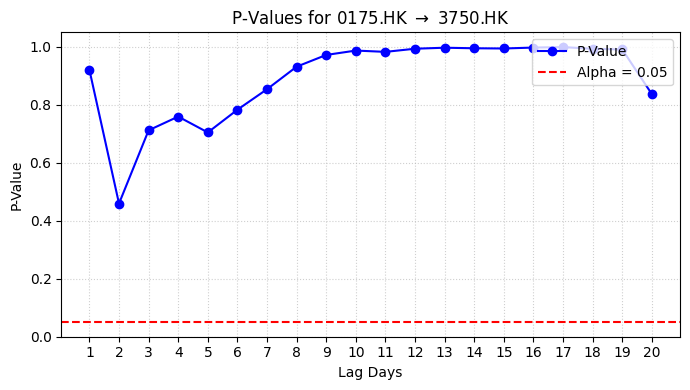

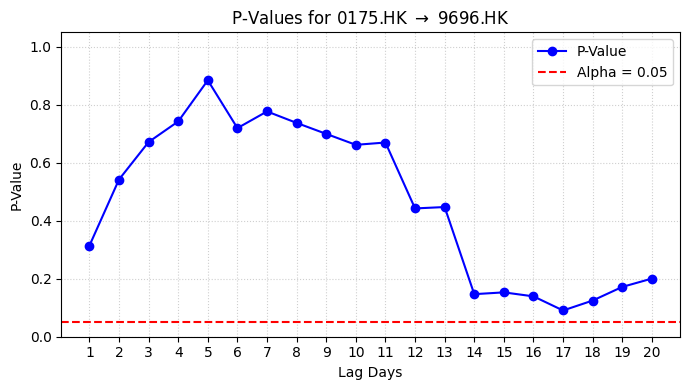

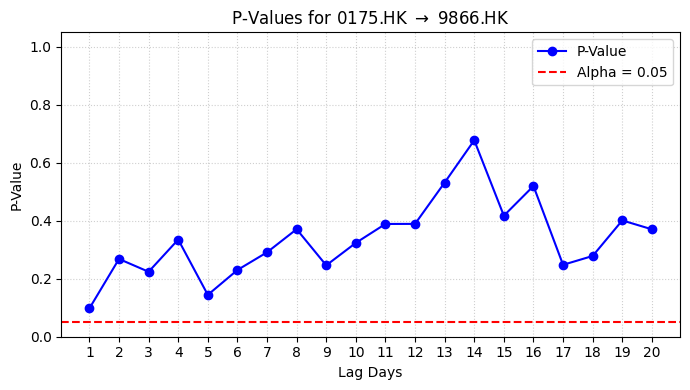

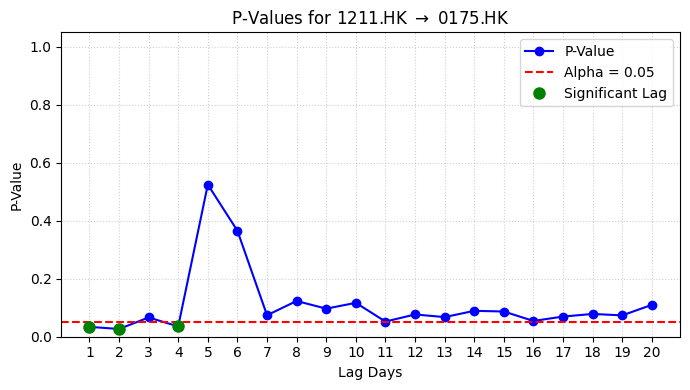

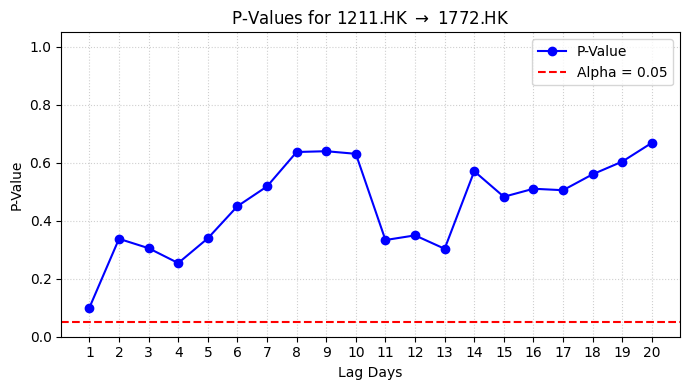

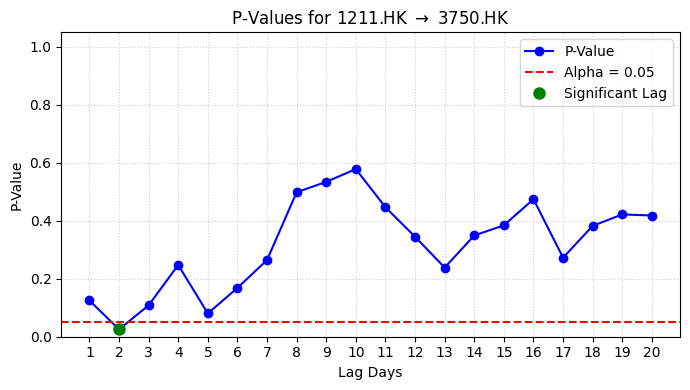

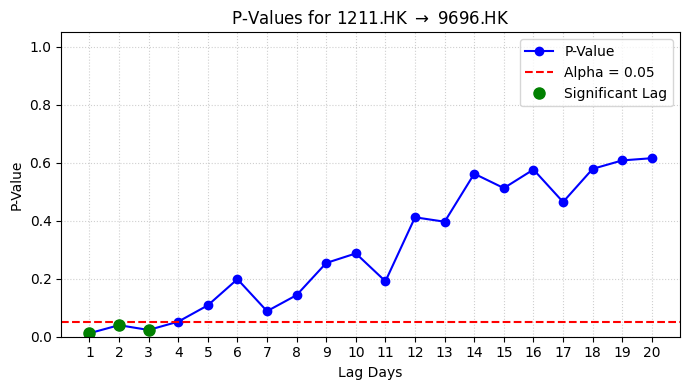

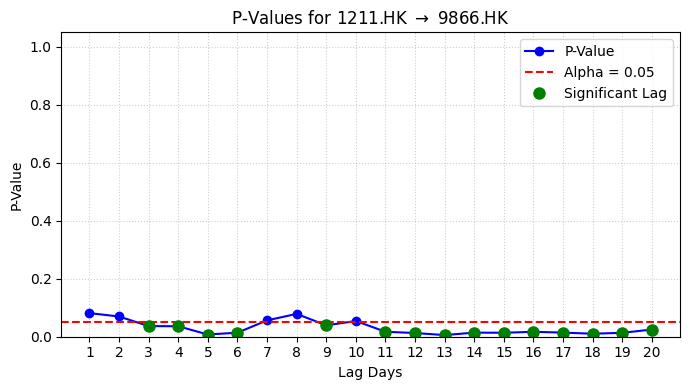

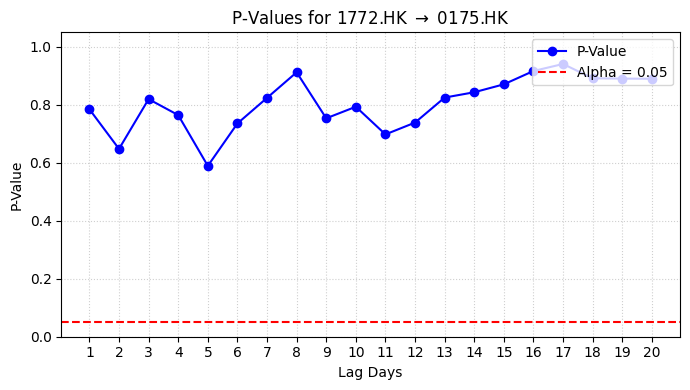

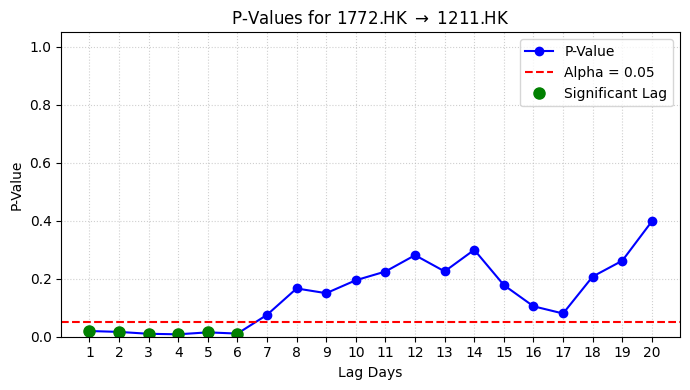

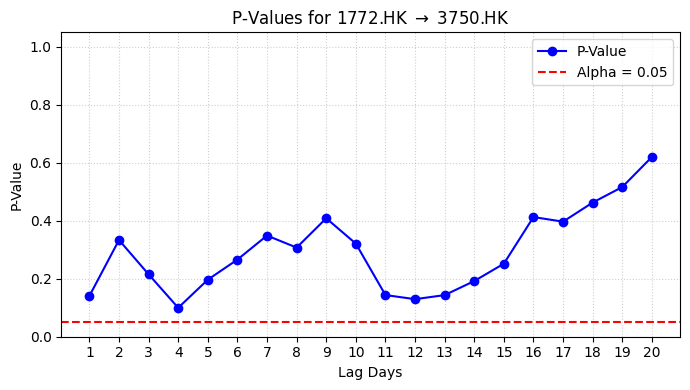

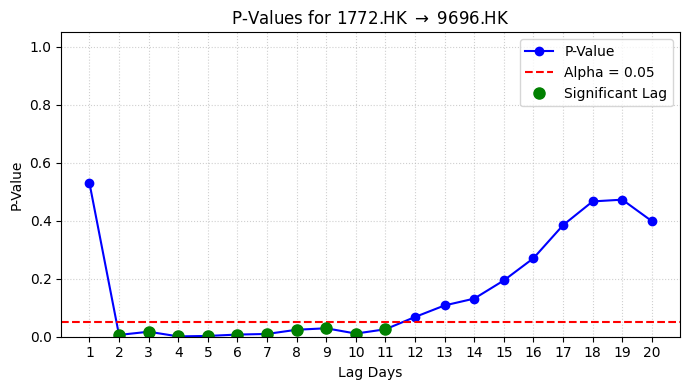

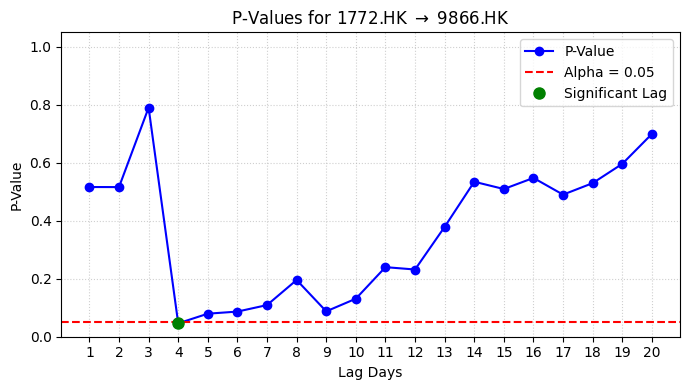

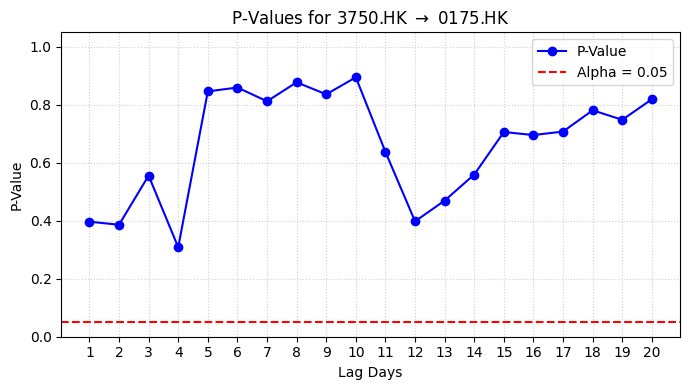

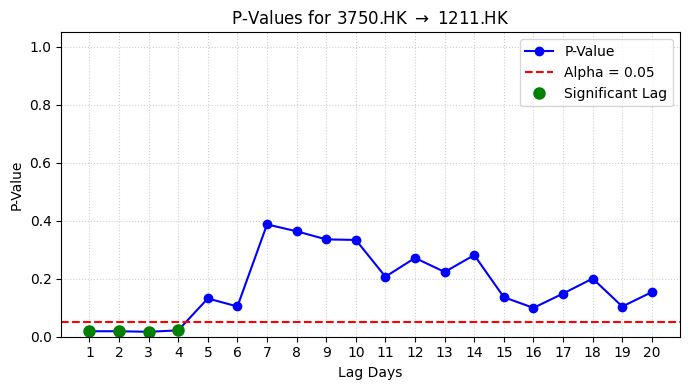

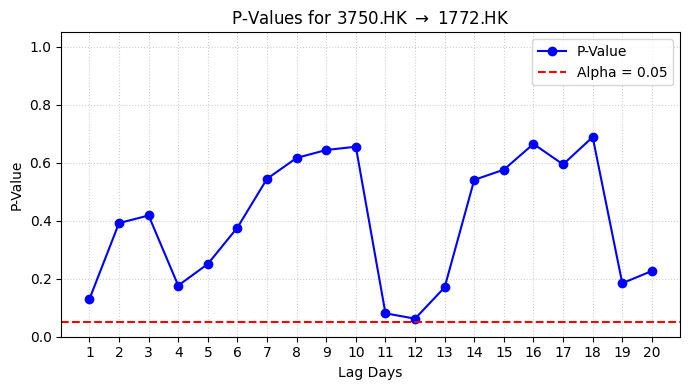

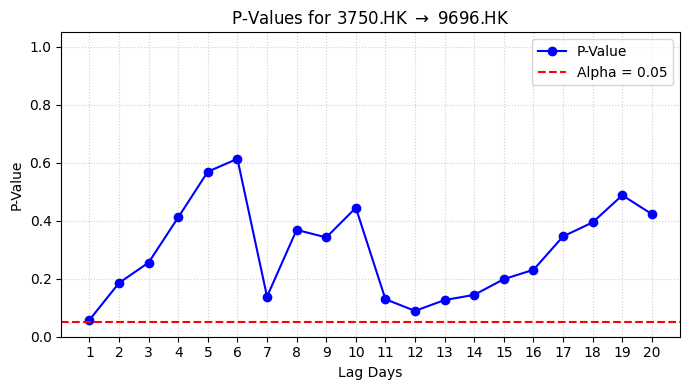

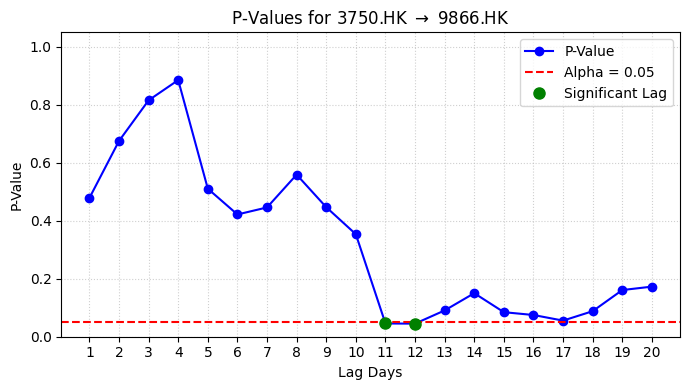

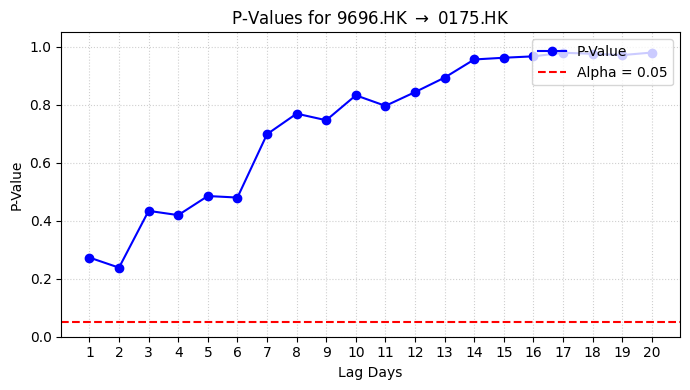

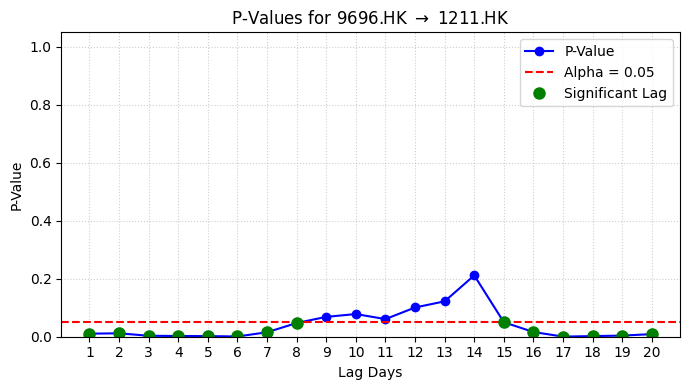

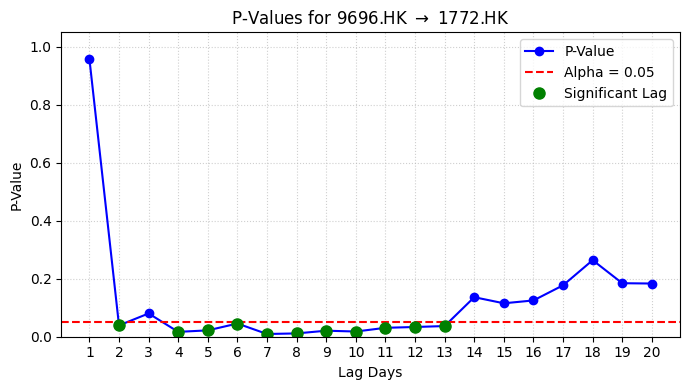

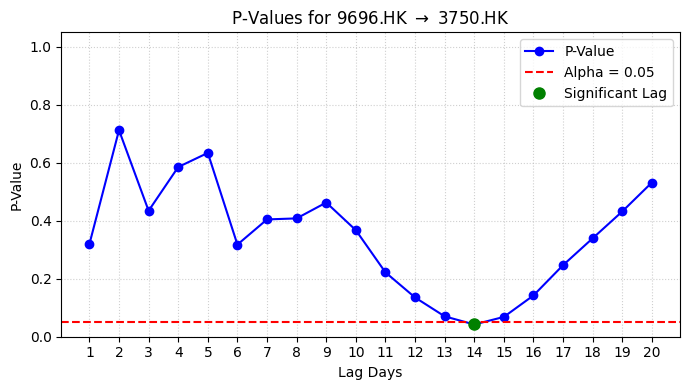

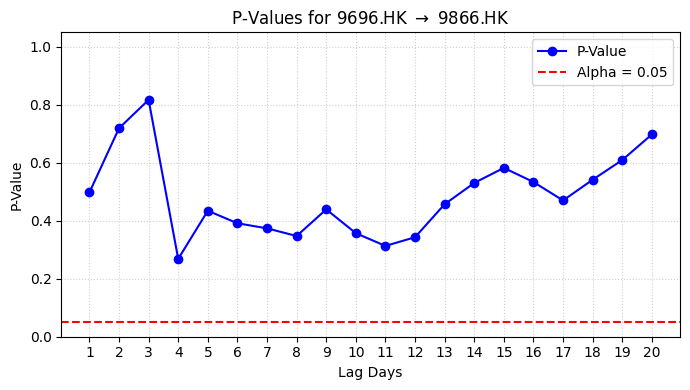

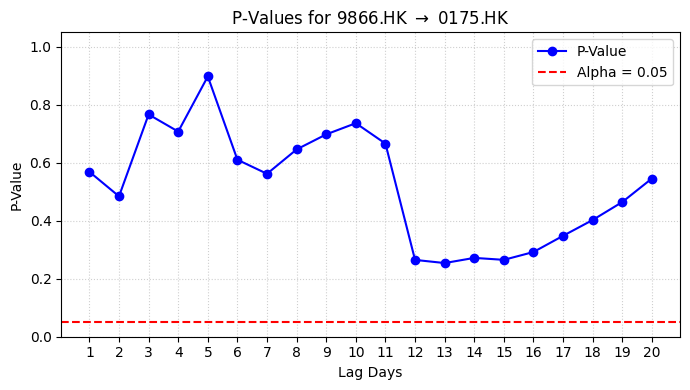

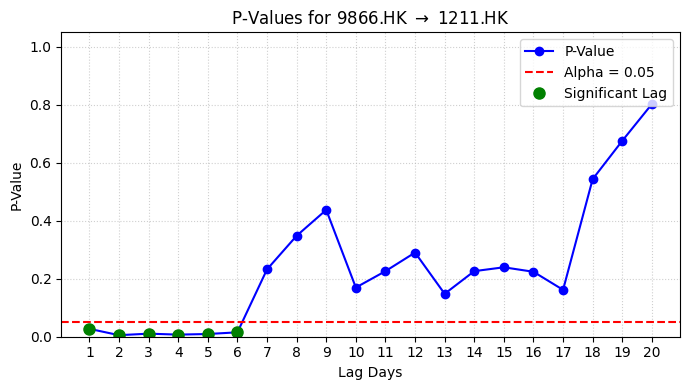

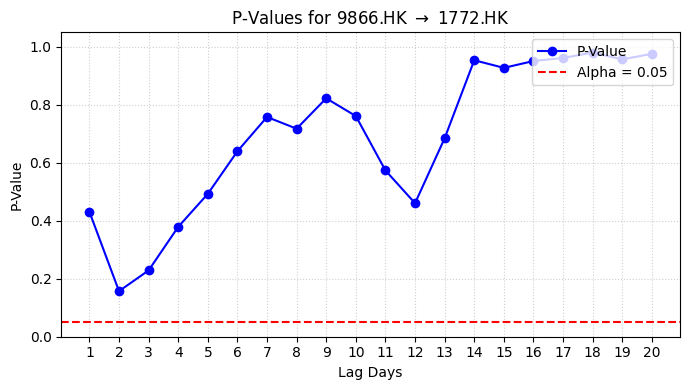

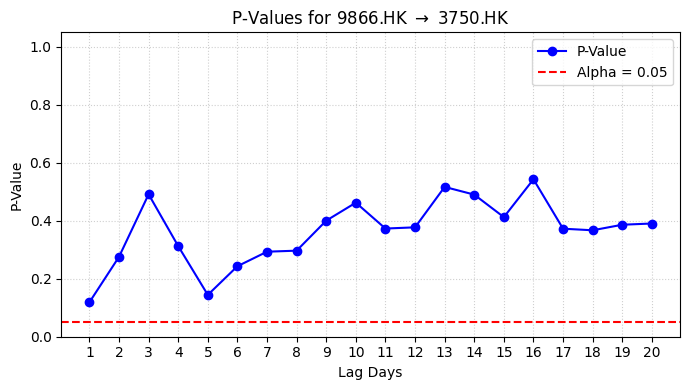

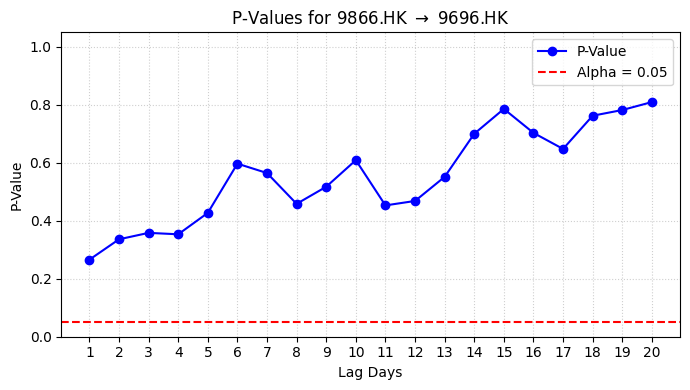

In [23]:
alpha = 0.05
grouped_results = indices_granger_df.groupby(['Cause', 'Effect'])
unique_pairs = indices_granger_df[['Cause', 'Effect']].drop_duplicates().shape[0]
for name, group in grouped_results:
    cause = name[0]
    effect = name[1]

    plt.figure(figsize=(7, 4))
    
    # Plot the P-values
    plt.plot(group['Lag_Days'], group['P_Value'], 
             marker='o', linestyle='-', color='b', label='P-Value')
    
    # Add the significance threshold line (the crucial element)
    plt.axhline(y=alpha, color='r', linestyle='--', label=f'Alpha = {alpha}')
    
    # Highlight significant lags (where P-Value < alpha)
    significant_lags = group[group['P_Value'] < alpha]
    if not significant_lags.empty:
        plt.plot(significant_lags['Lag_Days'], significant_lags['P_Value'], 
                 'o', color='g', markersize=8, label='Significant Lag')
    
    # Add labels and title
    plt.title(f'P-Values for {cause} $\\to$ {effect}')
    plt.xlabel('Lag Days')
    plt.ylabel('P-Value')
    plt.xticks(group['Lag_Days']) # Ensure all lag days are shown
    plt.ylim(0, 1.05) # Set y-limit from 0 to slightly above 1
    plt.legend(loc='upper right')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    
    plt.show()

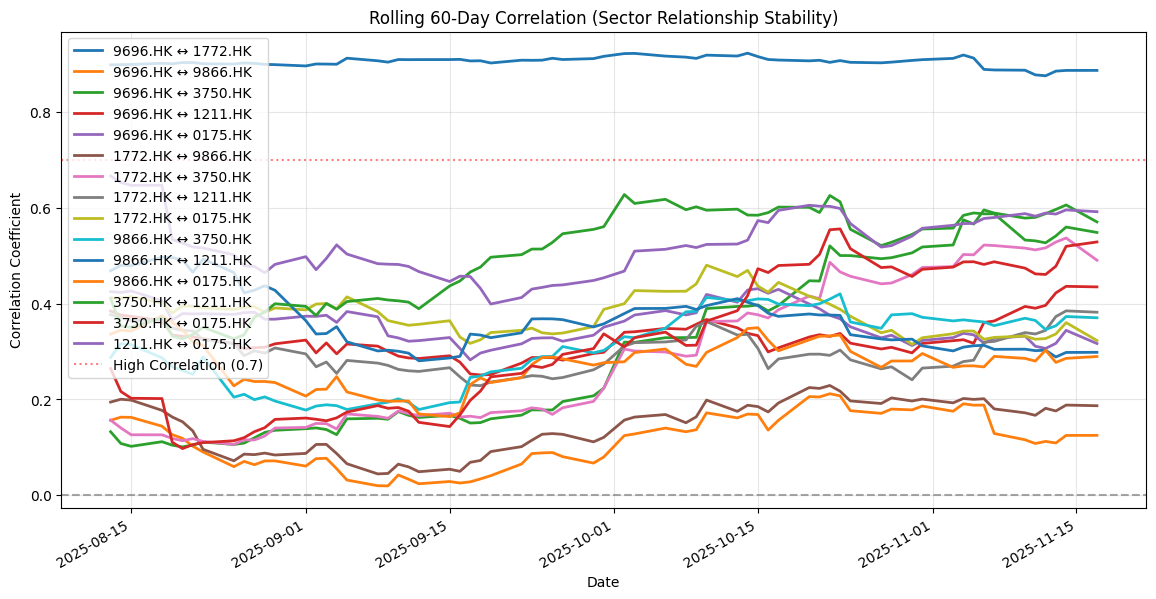

In [24]:
# --- ROLLING CORRELATION ANALYSIS ---

# Calculate rolling correlations for all unique pairs
rolling_corrs = pd.DataFrame(index=indices_daily_return.index)

for i in range(len(TICKERS)):
    for j in range(i + 1, len(TICKERS)):
        ticker1 = TICKERS[i]
        ticker2 = TICKERS[j]
        
        corr_series = indices_daily_return[ticker1].rolling(window=ROLLING_CORR_WINDOW).corr(indices_daily_return[ticker2])
        rolling_corrs[f'{ticker1} ↔ {ticker2}'] = corr_series

plt.figure(figsize=(14, 7))
rolling_corrs.plot(ax=plt.gca(), linewidth=2)
plt.title(f'Rolling {ROLLING_CORR_WINDOW}-Day Correlation (Sector Relationship Stability)')
plt.xlabel('Date')
plt.ylabel('Correlation Coefficient')
plt.axhline(0.7, color='red', linestyle=':', alpha=0.5, label='High Correlation (0.7)')
plt.axhline(0, color='grey', linestyle='--', alpha=0.7)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()


